# 10. 形态点位
*盘整形态是等待趋势的机会*

## 目录
1. 什么是形态?
2. 如何找到高低转折点？
3. 各种形态的计算条件是什么？
4. 如何把形态用图展示出来？
5. 如何将形态编写成策略？

## 什么是形态?
价格形态的变化往往预示着上升趋势和下降趋势之间的转变。根据定义，价格形态是一种可识别的价格变动结构，通过一系列趋势线或曲线来确定。当价格形态显示趋势方向的变化时，它被称为反转模式;当趋势在短暂停顿后继续存在时，就会出现持续模式。长期以来，技术分析师一直使用价格形态来检验当前的走势，并预测未来的市场走势。

## 如何找到高低转折点？
通过当两条EMA发生金叉，就往回一段时间（10天）找最低点。
通过当两条EMA发生死叉，就往回一段时间（10天）找最高点。

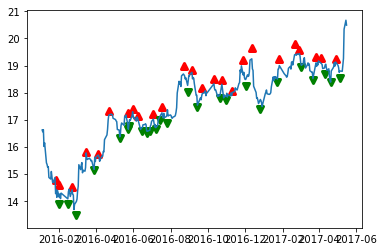

In [1]:
import talib as ta
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = ts.get_k_data('600036', start='2016-01-01', ktype='D',autype='qfq')
data.index = pd.to_datetime(data['date'],format='%Y-%m-%d')

data['EMA2'] = ta.abstract.EMA(data, 2)
data['EMA5'] = ta.abstract.EMA(data, 5)
data.pop('date')


def low_rolling(frame):
    if frame['EMA2'][-1] > frame["EMA5"][-1] and (frame['EMA2'][-2] < frame["EMA5"][-2]):
        return frame['low'].idxmin(), frame['low'].min()  
    else:
        return None

def high_rolling(frame):
    if frame['EMA2'][-1] < frame["EMA5"][-1] and (frame['EMA2'][-2] > frame["EMA5"][-2]):
        return frame['high'].idxmax(), frame['high'].max()
    else:
        return None

def rolling(data, function, window=10):
    for i in range(window, len(data)):
        value = function(data.iloc[i-window: i])
        if value:
            yield value #把方法编程生成器，可以用for循环


high_dict = dict(rolling(data, high_rolling))
low_dict = dict(rolling(data, low_rolling))

plt.plot(data['close'])
plt.scatter(high_dict.keys(), high_dict.values(), c='r', marker='^', linewidths=3)
plt.scatter(low_dict.keys(), low_dict.values(), c='g', marker='v', linewidths=3)
plt.show()

## 各种形态的计算条件是什么？
1. 三角形
    - 扩散三角形

        Top:
        - P1=highest
        - P1< P3< P5
        - P2 > P4
        
    - 收敛三角形
        Top:
        - P1=highest
        - P1> P3> P5
        - P2 < P4

2. 矩形
    Top:
    - P1=highest
    - P1,P3,P5 < (P1+P3+P5)/3*1.01
    - P1,P3,P5 > (P1+P3+P5)/3*0.99
    - P2,P4 < (P2+P4)/2*1.01

3. 头肩底
    - P1=Lowest
    - P3< P1, P3< P5
    - P1, P5 < (P1+P5)/2*1.01
    - P2, P4 < (P2+P4)/2*1.01

date               
2016-01-26  highest    14.790
2016-02-15  lowest     13.906
2016-02-22  highest    14.521
2016-02-29  lowest     13.492
2016-03-16  highest    15.808
2016-03-29  lowest     15.145
2016-04-22  highest    17.317
2016-05-10  lowest     16.318
2016-05-23  highest    17.269
2016-05-24  lowest     16.645
2016-06-01  highest    17.385
2016-06-24  lowest     16.510
2016-07-04  highest    17.221
2016-07-08  lowest     16.673
2016-07-18  highest    17.490
2016-07-27  lowest     16.890
2016-08-23  highest    19.000
2016-08-29  lowest     18.030
2016-09-05  highest    18.820
2016-09-14  lowest     17.480
2016-10-11  highest    18.490
2016-10-21  lowest     17.820
2016-10-25  highest    18.460
2016-10-31  lowest     17.720
2016-11-28  highest    19.200
2016-12-02  lowest     18.240
2016-12-12  highest    19.650
2016-12-26  lowest     17.390
2017-02-21  highest    19.810
2017-03-22  lowest     18.480
2017-03-27  highest    19.320
2017-04-20  lowest     18.380
2017-04-28  highest 

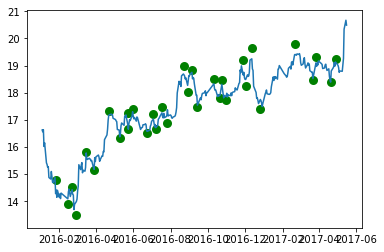

In [2]:
# 生成DataFrame处理
highest_series = pd.Series(high_dict.values(), index=high_dict.keys())
lowest_series = pd.Series(low_dict.values(), index=low_dict.keys())
data['highest'] = highest_series
data['lowest'] = lowest_series

point = pd.concat([data[['highest']], data['lowest']], axis=1).dropna(how='all')


def gap_index(multi_series):
    last = multi_series.index[0]
    
    for index in multi_series.index[1:]:
        if index[1] == last[1]:
            if index[1] == 'lowest':
                if multi_series.loc[index] < multi_series.loc[last]:
                    last = index
            else:
                if multi_series.loc[index] > multi_series.loc[last]:
                    last = index
                
        else:
            out = (last[0], last[1])
            last = index
            yield out

point = point.stack()
P_result = point.loc[list(gap_index(point))]
print P_result
print P_result.index

times = map(lambda index: index[0], P_result.index)

plt.plot(data['close'])
plt.scatter(times, P_result.values, c='g', marker='o', linewidths=3)

plt.show()

In [3]:
def slices(MI):
    for i in range(5, len(MI)):
        T = MI.iloc[i-5: i]
        if Triangle_pattern(T):
            yield T

def Triangle_pattern(df):
    if df.index.labels[1][0] == 0:
        if df.iloc[0]>df.iloc[2] and df.iloc[2]>df.iloc[4]:
            if df.iloc[1]<df.iloc[3]:
                return True

Triangle = pd.concat(list(slices(P_result)))

print Triangle

date               
2016-09-05  highest    18.82
2016-09-14  lowest     17.48
2016-10-11  highest    18.49
2016-10-21  lowest     17.82
2016-10-25  highest    18.46
dtype: float64


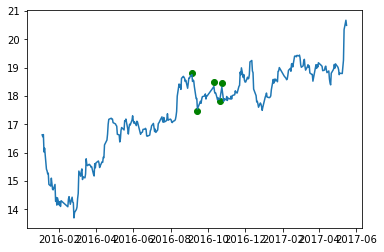

In [4]:
time_triangle = map(lambda index: index[0], Triangle.index)

plt.plot(data['close'])
plt.scatter(time_triangle, Triangle.values, c='g', marker='o', linewidths=1)
plt.show()

In [5]:
#正方形 Retangle
def slices(MI):
    for i in range(5, len(MI)):
        T = MI.iloc[i-5: i]
        if Retangle_pattern(T):
            yield T

def Retangle_pattern(df):
    
    cond_h = df.index.labels[1]==0
    cond_l = df.index.labels[1]==1
    df_h = df[cond_h]
    df_l = df[cond_l]
    mean_h = sum(df_h)/len(df_h)
    mean_l = sum(df_l)/len(df_l)

    def match0(df):
        if df.index.labels[1][0]==1:
            return False
        else:
            return True
        
    def match_1(H,L):
        if min(H)<max(L):
            return False
        else:
            return True
    
    def match_2(H):
        for high in H:
            if high>mean_h*1.01 or high<mean_h*0.99:
                return False
        return True
    
    def match_3(L):
        for low in L:
            if low<mean_l*0.99 or low>mean_l*1.01:
                return False
        return True

    return match0(df) and match_1(df_h, df_l) and match_2(df_h) and match_3(df_l)

retangle = pd.concat(list(slices(P_result)))

print retangle

date               
2016-04-22  highest    17.317
2016-05-10  lowest     16.318
2016-05-23  highest    17.269
2016-05-24  lowest     16.645
2016-06-01  highest    17.385
2016-05-23  highest    17.269
2016-05-24  lowest     16.645
2016-06-01  highest    17.385
2016-06-24  lowest     16.510
2016-07-04  highest    17.221
2016-06-01  highest    17.385
2016-06-24  lowest     16.510
2016-07-04  highest    17.221
2016-07-08  lowest     16.673
2016-07-18  highest    17.490
dtype: float64


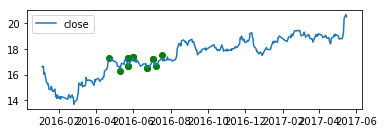

In [25]:
time_retangle = map(lambda index: index[0], retangle.index)

plt.subplot(2,1,1)
plt.plot(data['close'])
plt.scatter(time_retangle, retangle, c='g', marker='o', linewidths=1)
plt.legend()
plt.show()

## 如何将形态编写成策略？
选出处于高位收敛三角形的股票
1. 读取每一只股票过去五天的高低点
2. 对这些高低点进行条件判断
3. 满足条件的股票返回True

## 作业
熟悉MultiIndex的应用，并且还一直股票来寻找形态。